In [8]:
# Importera nödvändiga bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

# Ladda data
df = pd.read_csv('cardio_train.csv', sep=';')

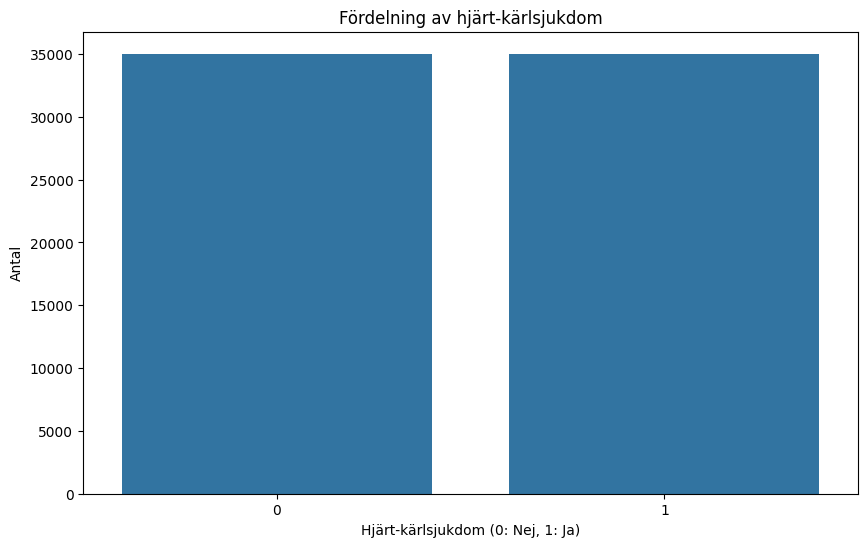

Antal negativa fall (0): 35021
Antal positiva fall (1): 34979
Andel positiva fall: 49.97%


In [9]:

# 1.1 EDA (Exploratory Data Analysis)

# a) Hur många är positiva/negativa för hjärt-kärlsjukdom
cardio_counts = df['cardio'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=cardio_counts.index, y=cardio_counts.values)
plt.title('Fördelning av hjärt-kärlsjukdom')
plt.xlabel('Hjärt-kärlsjukdom (0: Nej, 1: Ja)')
plt.ylabel('Antal')
plt.show()

print(f"Antal negativa fall (0): {cardio_counts[0]}")
print(f"Antal positiva fall (1): {cardio_counts[1]}")
print(f"Andel positiva fall: {(cardio_counts[1]/len(df))*100:.2f}%")


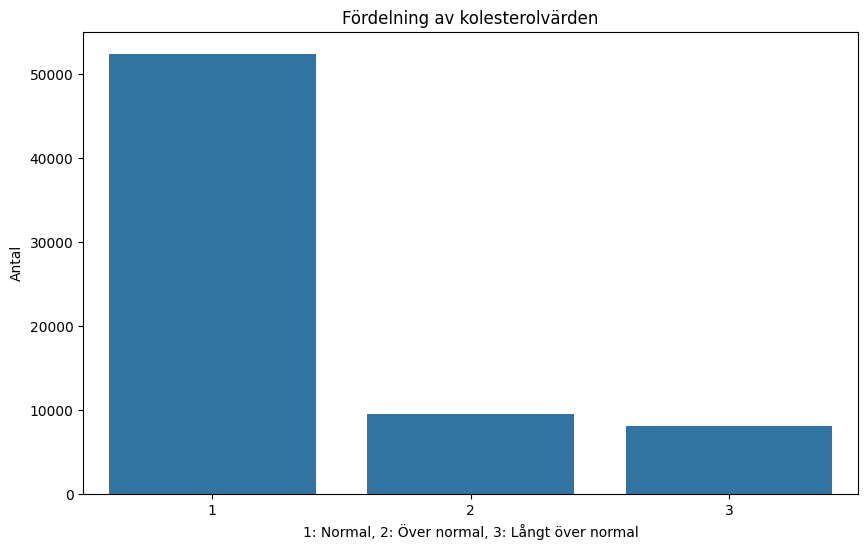

Andel med kolesterolvärde 1: 74.84%
Andel med kolesterolvärde 2: 13.64%
Andel med kolesterolvärde 3: 11.52%


In [10]:

# b) Kolesterolvärden
chol_counts = df['cholesterol'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=chol_counts.index, y=chol_counts.values)
plt.title('Fördelning av kolesterolvärden')
plt.xlabel('1: Normal, 2: Över normal, 3: Långt över normal')
plt.ylabel('Antal')
plt.show()

for i in [1, 2, 3]:
    print(f"Andel med kolesterolvärde {i}: {(chol_counts[i]/len(df))*100:.2f}%")



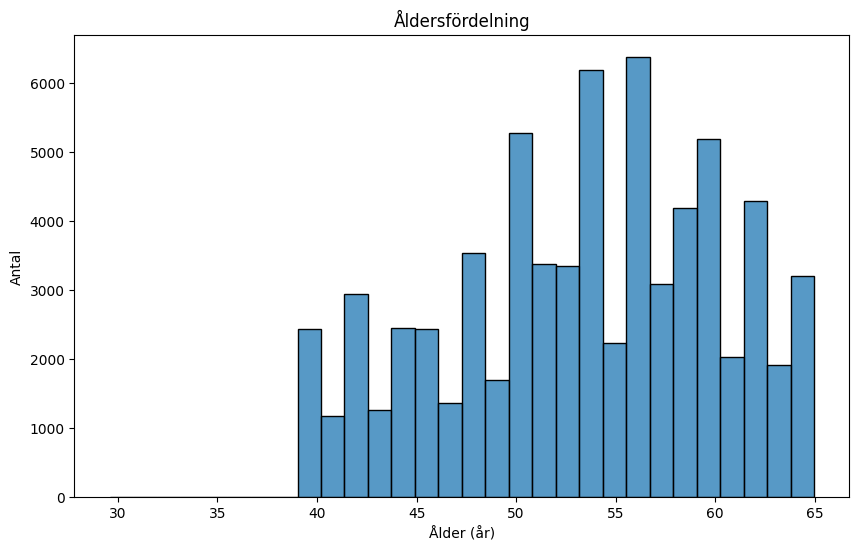

Medelålder: 53.3 år
Medianålder: 54.0 år


In [11]:

# c) Åldersfördelning
df['age_years'] = df['age'] / 365
plt.figure(figsize=(10, 6))
sns.histplot(df['age_years'], bins=30)
plt.title('Åldersfördelning')
plt.xlabel('Ålder (år)')
plt.ylabel('Antal')
plt.show()

print(f"Medelålder: {df['age_years'].mean():.1f} år")
print(f"Medianålder: {df['age_years'].median():.1f} år")


Andel som röker: 8.81%


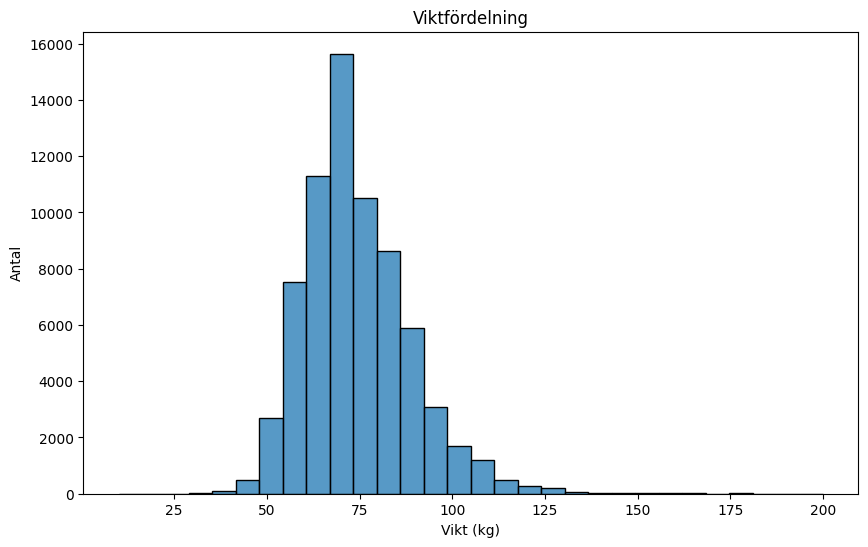

Medelvikt: 74.2 kg
Medianvikt: 72.0 kg


In [12]:

# d) Andel som röker
smoke_counts = df['smoke'].value_counts()
print(f"Andel som röker: {(smoke_counts[1]/len(df))*100:.2f}%")

# e) Viktfördelning
plt.figure(figsize=(10, 6))
sns.histplot(df['weight'], bins=30)
plt.title('Viktfördelning')
plt.xlabel('Vikt (kg)')
plt.ylabel('Antal')
plt.show()

print(f"Medelvikt: {df['weight'].mean():.1f} kg")
print(f"Medianvikt: {df['weight'].median():.1f} kg")


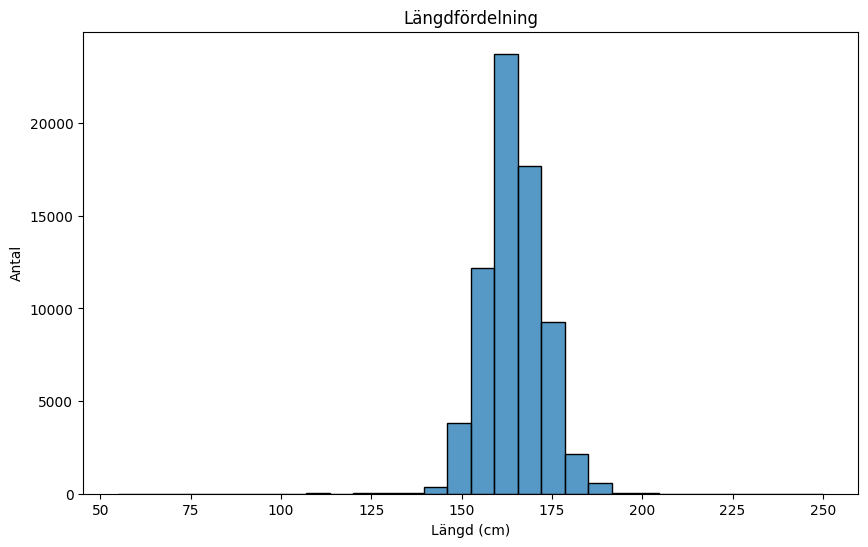

Medellängd: 164.4 cm
Medianlängd: 165.0 cm


In [13]:
# f) Längdfördelning
plt.figure(figsize=(10, 6))
sns.histplot(df['height'], bins=30)
plt.title('Längdfördelning')
plt.xlabel('Längd (cm)')
plt.ylabel('Antal')
plt.show()

print(f"Medellängd: {df['height'].mean():.1f} cm")
print(f"Medianlängd: {df['height'].median():.1f} cm")


<Figure size 1000x600 with 0 Axes>

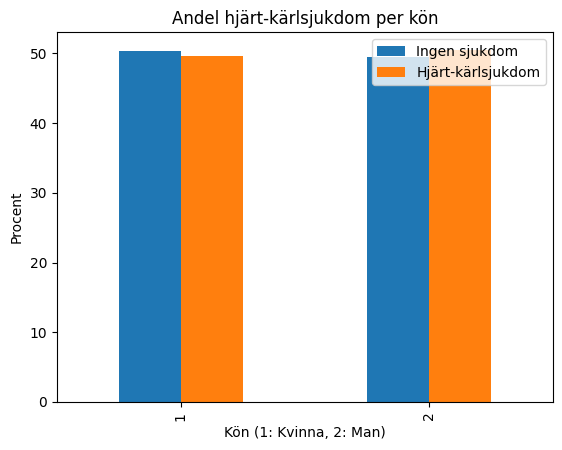


Andel hjärt-kärlsjukdom per kön:
cardio          0          1
gender                      
1       50.327257  49.672743
2       49.476911  50.523089


In [14]:
# g) Andel hjärt-kärlsjukdom per kön
gender_disease = pd.crosstab(df['gender'], df['cardio'], normalize='index') * 100
plt.figure(figsize=(10, 6))
gender_disease.plot(kind='bar')
plt.title('Andel hjärt-kärlsjukdom per kön')
plt.xlabel('Kön (1: Kvinna, 2: Man)')
plt.ylabel('Procent')
plt.legend(['Ingen sjukdom', 'Hjärt-kärlsjukdom'])
plt.show()

print("\nAndel hjärt-kärlsjukdom per kön:")
print(gender_disease)


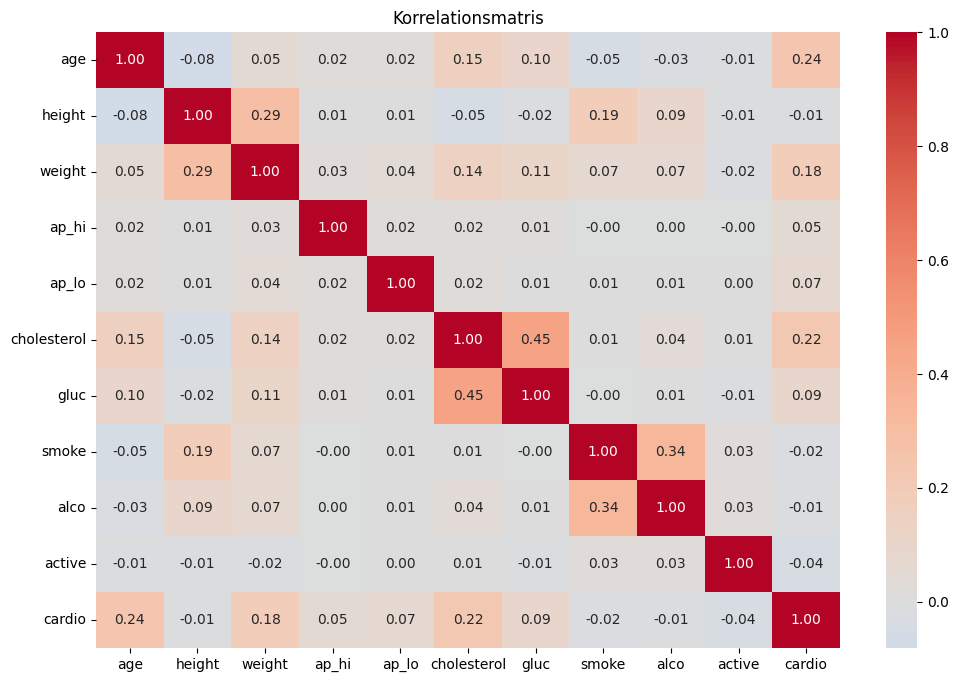

In [15]:
# 1.2 Korrelationsmatris
numeric_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Korrelationsmatris')
plt.show()


In [16]:
# 1.2.1 Feature Engineering
# Beräkna BMI
df['BMI'] = df['weight'] / ((df['height']/100) ** 2)

# Ta bort orimliga BMI-värden (under 15 eller över 50)
print(f"\nAntal rader före BMI-filtrering: {len(df)}")
df = df[(df['BMI'] >= 15) & (df['BMI'] <= 50)]
print(f"Antal rader efter BMI-filtrering: {len(df)}")

# Skapa BMI-kategorier
def get_bmi_category(bmi):
    if bmi < 18.5:
        return 'normal_range'
    elif bmi < 25:
        return 'normal_range'
    elif bmi < 30:
        return 'overweight'
    elif bmi < 35:
        return 'obese_1'
    elif bmi < 40:
        return 'obese_2'
    else:
        return 'obese_3'

df['BMI_category'] = df['BMI'].apply(get_bmi_category)




Antal rader före BMI-filtrering: 70000
Antal rader efter BMI-filtrering: 69729


In [17]:

# Ta bort orimliga blodtrycksvärden
print(f"\nAntal rader före blodtrycksfiltrering: {len(df)}")
df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 300) & 
        (df['ap_lo'] > 0) & (df['ap_lo'] < 200) &
        (df['ap_hi'] > df['ap_lo'])]
print(f"Antal rader efter blodtrycksfiltrering: {len(df)}")

# Skapa blodtryckskategorier
def get_bp_category(systolic, diastolic):
    if systolic < 120 and diastolic < 80:
        return 'normal'
    elif systolic < 130 and diastolic < 80:
        return 'elevated'
    elif systolic < 140 or diastolic < 90:
        return 'hypertension_1'
    else:
        return 'hypertension_2'

df['BP_category'] = df.apply(lambda x: get_bp_category(x['ap_hi'], x['ap_lo']), axis=1)




Antal rader före blodtrycksfiltrering: 69729
Antal rader efter blodtrycksfiltrering: 68447


In [18]:

# 1.2.2 Skapa två dataset
# Dataset 1 med kategoriska variabler
df1 = df.copy()
categorical_columns = ['BMI_category', 'BP_category', 'gender']
df1 = pd.get_dummies(df1, columns=categorical_columns)
df1.drop(['ap_hi', 'ap_lo', 'height', 'weight', 'BMI', 'id'], axis=1, inplace=True)

# Dataset 2 med numeriska variabler
df2 = df.copy()
df2 = pd.get_dummies(df2, columns=['gender'])
df2.drop(['BMI_category', 'BP_category', 'height', 'weight', 'id'], axis=1, inplace=True)


In [19]:
# 1.2.3 Träning och utvärdering av modeller
X1 = df1.drop('cardio', axis=1)
y1 = df1['cardio']
X2 = df2.drop('cardio', axis=1)
y2 = df2['cardio']

# Skala data
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)

# Definiera modeller och parametrar
models = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    }),
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1.0, 10.0]
    }),
    'SVM': (SVC(probability=True), {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear']
    })
}

In [ ]:

# Träna och utvärdera modeller
results = {}
for name, (model, params) in models.items():
    # Dataset 1
    grid1 = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid1.fit(X1_scaled, y1)
    
    # Dataset 2
    grid2 = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid2.fit(X2_scaled, y2)
    
    results[name] = {
        'dataset1': {'score': grid1.best_score_, 'params': grid1.best_params_},
        'dataset2': {'score': grid2.best_score_, 'params': grid2.best_params_}
    }


In [ ]:

# Visa resultat
for model_name, result in results.items():
    print(f"\nModell: {model_name}")
    print(f"Dataset 1 - Accuracy: {result['dataset1']['score']:.4f}")
    print(f"Dataset 1 - Bästa parametrar: {result['dataset1']['params']}")
    print(f"Dataset 2 - Accuracy: {result['dataset2']['score']:.4f}")
    print(f"Dataset 2 - Bästa parametrar: {result['dataset2']['params']}")

# 1.3 Paketering och demo
# Välj 100 slumpmässiga rader för test
test_indices = np.random.choice(len(df1), 100, replace=False)
test_samples = df1.iloc[test_indices]
train_samples = df1.drop(test_indices)

# Spara test samples
test_samples.to_csv('test_samples.csv', index=False)

# Träna final modell (använder RandomForest som exempel)
best_model = RandomForestClassifier(**results['RandomForest']['dataset1']['params'])
X_train = train_samples.drop('cardio', axis=1)
y_train = train_samples['cardio']
best_model.fit(X_train, y_train)

In [ ]:
# Spara modellen
joblib.dump(best_model, 'heart_disease_model.pkl')